# Transformer Experiments

building basic decoder-only transformers and experimenting on them  
goal here is lower-level familiarity with transformers beyond fine-tuning or applications, not maximal efficiency or performance  

In [1]:
# from huggingface_hub import login

# login()

In [2]:
!nvidia-smi

Sun Aug 31 13:00:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.04              Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:09:00.0  On |                  N/A |
| 34%   60C    P0            178W /  575W |    2152MiB /  32607MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### imports

In [3]:
"""
intentionally simple starter decoder-only LLM w/ old school choices like MHA, smol size for iteration (few hundred M ish)
"""
from __future__ import annotations
import math
import os
import sys
import time
import argparse
from dataclasses import dataclass
from typing import Optional
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from transformers import AutoTokenizer, PreTrainedTokenizerBase

import json
from datetime import datetime
from pathlib import Path
from typing import Any, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset
import torch

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, force=True)
logger.setLevel(logging.INFO)

# Ensure a stream handler to stdout
if not any(isinstance(h, logging.StreamHandler) for h in logger.handlers):
    h = logging.StreamHandler(sys.stdout)
    h.setLevel(logging.INFO)
    h.setFormatter(
        logging.Formatter("[%(asctime)s] %(levelname)s %(message)s", "%H:%M:%S")
    )
    logger.addHandler(h)

# Avoid double logging via root if it’s configured differently
logger.propagate = False

logger.info("Logger configured and ready.")

/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[13:00:58] INFO Logger configured and ready.


### Basic decoder-only arch

In [4]:
@dataclass
class Config:
    vocab_size: int = 32_000
    d_model: int = 1_024  # width
    n_heads: int = 16
    n_layers: int = 24
    d_mlp: int = 4_096  # 4x model dim
    max_seq_len: int = 1_024  # context len
    dropout: float = 0.1  # for both attention & MLP layers, will be tuned later
    micro_batch_size: int = 8
    effective_batch_size: int = 512  # accumulate to this size
    token_budget: int = 200_000_000  # 200M good enough for learning purposes
    peak_lr: float = 3e-4
    min_lr_ratio: float = 0.1  # cosine schedule
    warmup_steps: int = 2_000
    betas: tuple[float, float] = (0.9, 0.95)  # for AdamW optimizer
    weight_decay: float = 0.1
    grad_clip: float = 1.0
    use_bf16: bool = True
    log_interval: int = 100
    val_interval: int = 1_000
    val_batches: int = 50
    attn_hist_layers: list[int] = (0, 12, 23)  # histograms
    spm_model_path: Optional[str] = None  # tokenizer
    verbose_logs: bool = True
    # extras
    use_sdpa: bool = True
    ema_decay: float = 0.999
    use_ema_eval: bool = True
    # memory/speed
    use_act_checkpoint: bool = True


class HFTokenizerAdapter:
    """
    Thin wrapper over a pretrained HuggingFace tokenizer.
    Includes a bytes-per-token estimator useful for bpb metrics.

    Notes:
    - Word-boundary markers:
        * GPT-2/BPE-style uses "Ġ" for a leading space.
        * SentencePiece uses "▁" for a leading space.
    - Byte-fallback tokens often look like "<0xAB>" and should count as 1 byte.
    """

    def __init__(self, name_or_path: str):
        tok: PreTrainedTokenizerBase = AutoTokenizer.from_pretrained(
            name_or_path,
            use_fast=True,
            trust_remote_code=False,
        )
        self.tok = tok
        # Avoid HF warning about model_max_length (GPT-2 default 1024).
        # We pack fixed-length windows ourselves, so set a very large max_length.
        try:
            prev_max = getattr(self.tok, 'model_max_length', None)
            self.tok.model_max_length = int(1e9)
        except Exception:
            pass
        # Common special IDs (may be None depending on tokenizer)
        self.bos_id = getattr(self.tok, 'bos_token_id', None)
        self.eos_id = getattr(self.tok, 'eos_token_id', None)
        self.vocab_size = int(self.tok.vocab_size)
        # Cache for quick checks
        self._special_tokens = set(getattr(self.tok, "all_special_tokens", []))

    def encode(self, text: str) -> list[int]:
        return self.tok.encode(text, add_special_tokens=False)

    def decode(self, ids: list[int]) -> str:
        return self.tok.decode(ids, skip_special_tokens=True)

    def _token_byte_len(self, token_str: str) -> int:
        # Treat leading word-boundary markers as a space (1 byte), then measure the core
        if token_str.startswith("Ġ") or token_str.startswith("▁"):
            core = token_str[1:]
            return 1 + len(core.encode("utf-8"))

        # Byte-fallback style tokens like "<0xAB>" → count as exactly 1 byte
        if (
            len(token_str) >= 5
            and token_str.startswith("<0x")
            and token_str.endswith(">")
        ):
            return 1

        # Special tokens (e.g., <s>, </s>, [PAD]) don't correspond to source bytes; count as 0
        if token_str in self._special_tokens:
            return 0

        # Default: UTF-8 length
        return len(token_str.encode("utf-8"))

    def bytes_per_token(self, ids: torch.Tensor) -> torch.Tensor:
        """
        Map token IDs → token strings → estimated byte lengths.
        Returns a tensor shaped like `ids` (float32) on the same device.
        """
        if not torch.is_tensor(ids):
            raise TypeError(f"`ids` must be a torch.Tensor, got {type(ids)}")

        flat = ids.view(-1).tolist()
        toks = self.tok.convert_ids_to_tokens(flat)
        lens = [self._token_byte_len(t) for t in toks]
        return torch.tensor(lens, dtype=torch.float32, device=ids.device).view_as(ids)


class MultiHeadSelfAttention(nn.Module):
    """
    Vanilla decoder-only MHSA for simplicity, as a starting point.
    - pre-norm
    - dropout
    """

    def __init__(self, d_model: int, n_heads: int, dropout: float, max_seq_len: int, use_sdpa: bool = True):
        super().__init__()
        assert d_model % n_heads == 0, "model dim must be divisible by n heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.use_sdpa = bool(use_sdpa)

        # Projections from embed dim to QKV
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=True)
        self.out = nn.Linear(d_model, d_model, bias=True)

        # Causal mask
        mask = torch.full((1, 1, max_seq_len, max_seq_len), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        self.register_buffer("causal_mask", mask, persistent=False)

    def forward(
        self, x: torch.Tensor, need_attn: bool = False
    ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        B, T, C = x.size()  # batch, time, channels
        # TODO: B, T, C review

        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=-1)

        q = q.view(B, T, self.n_heads, self.d_head).transpose(
            1, 2
        )  # TODO: think about this reshape op
        k = k.view(B, T, self.n_heads, self.d_head).transpose(
            1, 2
        )  # TODO: think about this reshape op
        v = v.view(B, T, self.n_heads, self.d_head).transpose(
            1, 2
        )  # TODO: think about this reshape op

        # scaled dot product attention
        attn_probs = None
        if self.use_sdpa and not need_attn:
            y = F.scaled_dot_product_attention(
                q, k, v, attn_mask=None, dropout_p=self.dropout.p if self.training else 0.0, is_causal=True
            )
        else:
            # manual attention path (needed to return attn_probs for histograms)
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)
            attn_scores = attn_scores + self.causal_mask[..., :T, :T]
            attn_probs = F.softmax(attn_scores, dim=-1)
            attn_probs = self.dropout(attn_probs)
            y = torch.matmul(attn_probs, v)
        # restore to (B, T, C) format
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # TODO: again study the reshape op
        y = self.out(y)

        return (y, attn_probs) if need_attn else (y, None)


class MLP(nn.Module):
    """
    Vanilla feed forward / MLP
    LN -> linear -> GELU -> dropout -> linear -> dropout
    """

    def __init__(self, d_model: int, d_mlp: int, dropout: float):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_mlp)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(d_mlp, d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class DecoderBlock(nn.Module):
    """
    simple pre-norm decoder block
    """

    def __init__(
        self, d_model: int, n_heads: int, d_mlp: int, dropout: float, max_seq_len: int, use_sdpa: bool = True, use_act_checkpoint: bool = True):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, n_heads, dropout, max_seq_len, use_sdpa=use_sdpa)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, d_mlp, dropout)
        self.use_act_checkpoint = bool(use_act_checkpoint)
        self._logged_ckpt_once = False

    def forward(
        self, x: torch.Tensor, need_attn: bool = False
    ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        # Activation checkpointing (training only, and when we don't need attn probs)
        if self.use_act_checkpoint and self.training and not need_attn:
            if not self._logged_ckpt_once:
                try:
                    import logging as _logging
                    _logging.getLogger(__name__).info(
                        "Activation checkpointing active in DecoderBlock (logging once)."
                    )
                except Exception:
                    pass
                self._logged_ckpt_once = True
            def _body(inp: torch.Tensor) -> torch.Tensor:
                a, _ = self.attn(self.ln1(inp), need_attn=False)
                s = inp + a
                m = self.mlp(self.ln2(s))
                return s + m

            y = torch.utils.checkpoint.checkpoint(
                _body, x, use_reentrant=False, preserve_rng_state=True
            )
            return y, None

        # Standard path (or when attention probabilities are requested)
        a, attn_probs = self.attn(self.ln1(x), need_attn=need_attn)
        x = x + a
        m = self.mlp(self.ln2(x))
        x = x + m
        return x, attn_probs


class DecoderOnlyLM(nn.Module):
    """
    Basic version, GPT-2 style:
    - learned abs. pos. embeddings
    - pre norm
    (GELU, etc.)
    """

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.max_seq_len, cfg.d_model)

        self.blocks = nn.ModuleList(
            [
                DecoderBlock(
                    cfg.d_model, cfg.n_heads, cfg.d_mlp, cfg.dropout, cfg.max_seq_len,
                    use_sdpa=cfg.use_sdpa, use_act_checkpoint=cfg.use_act_checkpoint
                )
                for block in range(cfg.n_layers)
            ]
        )
        self.ln_f = nn.LayerNorm(cfg.d_model)

        # LM head weight tied to tok_emb
        self.lm_head = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)

        # Initialize weights (GPT-2 style) before tying
        self.apply(self._init_weights)
        self.lm_head.weight = self.tok_emb.weight  # weight tying

    def _init_weights(self, module):
        # GPT2 style
        if isinstance(module, (nn.Linear, nn.Embedding)):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(
        self, idx: torch.Tensor, need_attn_layers: Optional[list[int]] = None
    ) -> tuple[torch.Tensor, dict[int, torch.Tensor]]:
        """
        idx: (B, T) token IDs
        return:
                logits: (B, T, vocab)
                attn_store: dict[layer_idx -> attn_probs (B, H, T, T)] for requested layers
        """
        B, T = idx.size()
        assert T <= self.cfg.max_seq_len, "Context len exceeded"

        positions = torch.arange(0, T, device=idx.device, dtype=torch.long)
        x = self.tok_emb(idx) + self.pos_emb(positions)[None, :, :]  # dims B, T, C
        attn_store: dict[int, torch.Tensor] = dict()
        for layer_idx, block in enumerate(self.blocks):
            need_attn = need_attn_layers is not None and layer_idx in need_attn_layers
            x, attn = block(x, need_attn=need_attn)
            if need_attn and attn is not None:
                attn_store[layer_idx] = attn

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits, attn_store

#### training + helper funcs

In [5]:
# Helpers

from gc import enable
from math import cos
from sre_parse import Tokenizer


class WarmupCosineScheduler:
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        peak_lr: float,
        warmup_steps: int,
        total_steps: int,
        min_lr_ratio: float = 0.1,
        hold_ratio: float = 0.5,
    ):
        self.opt = optimizer
        self.peak_lr = float(peak_lr)
        self.warmup_steps = max(1, int(warmup_steps))
        self.total_steps = max(self.warmup_steps + 1, int(total_steps))
        self.min_lr = float(peak_lr) * float(min_lr_ratio)
        # Hold is a fraction of post-warmup steps
        remaining = max(1, self.total_steps - self.warmup_steps)
        self.hold_steps = max(0, int(remaining * float(hold_ratio)))
        self.step_num = 0
        self._set_lr(0.0)

    def _set_lr(self, lr: float):
        for g in self.opt.param_groups:
            g["lr"] = lr

    def step(self):
        self.step_num += 1
        if self.step_num <= self.warmup_steps:
            lr = self.peak_lr * (self.step_num / self.warmup_steps)
        elif self.step_num <= (self.warmup_steps + self.hold_steps):
            lr = self.peak_lr
        else:
            decay_steps = max(1, self.total_steps - self.warmup_steps - self.hold_steps)
            t = min(decay_steps, max(0, self.step_num - self.warmup_steps - self.hold_steps))
            progress = t / decay_steps
            cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
            lr = self.min_lr + (self.peak_lr - self.min_lr) * cosine
        self._set_lr(lr)
        return lr


LOG2E = 1.0 / math.log(2.0)  # nats -> bits


@torch.no_grad()
def evaluate_loss_and_metrics(
    model: DecoderOnlyLM,
    val_loader: DataLoader,
    tokenizer: HFTokenizerAdapter,
    device: torch.device,
    max_batches: int,
    want_attn_hist_layers: list[int],
) -> dict[str, object]:
    """
    compute loss metrics: bits per token, bits per bytes, loss by posn, attention distance hists for some layers
    """
    model.eval()
    ce_sum = 0.0
    tok_count = 0
    byte_loss_sum = 0.0
    byte_count = 0.0

    correct_sum = 0
    total_sum = 0

    pos_loss_sum = None
    pos_count = 0

    attn_hist: dict[int, torch.Tensor] = dict()
    T_max = model.cfg.max_seq_len

    batches = 0
    start = time.time()
    for x, y in val_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.autocast(
            device_type=device.type, dtype=torch.bfloat16, enabled=model.cfg.use_bf16
        ):
            logits, attn_store = model(
                x, need_attn_layers=want_attn_hist_layers if batches == 0 else None
            )

        # logits (B, T, V), y: (B, T)
        # compute CE in fp32 for numerical stability
        loss_per_token = F.cross_entropy(
            logits.float().view(-1, logits.size(-1)), y.view(-1), reduction="none"
        ).view_as(y)

        # next-token accuracy
        preds = logits.argmax(dim=-1)
        correct_sum += (preds == y).sum().item()
        total_sum += y.numel()

        ce_sum += loss_per_token.sum().item()
        tok_count += y.numel()

        # bits per byte, only for val
        bptok = tokenizer.bytes_per_token(y)
        byte_loss_sum += (loss_per_token * bptok).sum().item()
        byte_count += bptok.sum().item()

        pos_loss = loss_per_token.float().mean(dim=0)
        if pos_loss_sum is None:
            pos_loss_sum = pos_loss.clone()
        else:
            pos_loss_sum += pos_loss
        pos_count += 1

        # Attention distance histogram
        if batches == 0 and attn_store:
            # For each requested layer, build a histogram over distances 0..T-1
            # distance d = query_pos - key_pos (only k <= q in causal attention)
            for li, attn in attn_store.items():  # attn: (B, H, T, T)
                B, H, T, _ = attn.size()
                # Only the lower triangle is non-zero; build a mask of indices
                # We'll sum attention probs grouped by distance d
                attn = attn[:, :, :T, :T]  # (B,H,T,T)
                # Create an index matrix of distances: dist[q,k] = q - k
                # dist shape (T,T); broadcast to (B,H,T,T) after unsqueeze
                dist = torch.arange(T, device=attn.device).view(T, 1) - torch.arange(
                    T, device=attn.device
                ).view(1, T)
                dist = dist.clamp(min=0)  # ensure causal distances only
                # Flatten to bins 0..T-1
                hist = torch.zeros(T_max, device=attn.device, dtype=torch.float32)
                # Accumulate probs into bins
                for d in range(T):
                    mask = (dist == d).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)
                    mass_d = attn.masked_select(mask).sum()
                    hist[d] = mass_d
                # Normalize to probability distribution
                s = hist.sum()
                if s > 0:
                    hist = hist / s
                attn_hist[li] = hist.detach().cpu()

        batches += 1
        if batches >= max_batches:
            break

    elapsed = time.time() - start
    bpt = (ce_sum / tok_count) * LOG2E
    bpb = (byte_loss_sum / max(1.0, byte_count)) * LOG2E
    loss_by_pos = (
        (pos_loss_sum / pos_count).cpu().tolist() if pos_loss_sum is not None else []
    )

    acc = (correct_sum / max(1, total_sum)) if total_sum > 0 else 0.0

    return dict(
        bits_per_token=bpt,
        bits_per_byte=bpb,
        loss_by_position=loss_by_pos,
        attn_distance_hist={int(k): v.tolist() for k, v in attn_hist.items()},
        eval_time_sec=elapsed,
        tokens_evaluated=int(tok_count),
        accuracy=float(acc),
    )


def compute_param_count(model: nn.Model) -> int:
    return sum(p.numel() for p in model.parameters())


# Training


# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--spm_model",
#         type=str,
#         default=None,
#         help="Path to SentencePiece model (optional).",
#     )
#     parser.add_argument(
#         "--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu"
#     )
#     parser.add_argument(
#         "--compile",
#         action="store_true",
#         help="Use torch.compile for model (PyTorch 2.0+).",
#     )
#     parser.add_argument("--micro_bsz", type=int, default=8)
#     parser.add_argument("--eff_bsz", type=int, default=512)
#     parser.add_argument("--tokens", type=int, default=200_000_000)
#     parser.add_argument("--val_every", type=int, default=1000)
#     parser.add_argument("--log_every", type=int, default=100)
#     parser.add_argument("--nih_every", type=int, default=5000)
#     args = parser.parse_args()

#     cfg = Config(
#         spm_model_path=args.spm_model,
#         micro_batch_size=args.micro_bsz,
#         effective_batch_size=args.eff_bsz,
#         token_budget=args.tokens,
#         val_interval=args.val_every,
#         log_interval=args.log_every,
#         nih_eval_interval=args.nih_every,
#     )

#     device = torch.device(args.device)
#     tokenizer = HFTokenizerAdapter(cfg)

#     model = DecoderOnlyLM(cfg).to(device)
#     if args.compile and hasattr(torch, "compile"):
#         model = torch.compile(model, mode="max-autotune")

#     n_params = compute_param_count(model)
#     logger.info(f"Model config: {n_params/1e6:.2f}M | vocab={cfg.vocab_size} | layers={cfg.n_layers} | d={cfg.d_model} | heads={cfg.n_heads}")

#     # Data: for a *real* run, replace RandomTokenStream with your dataset.
#     # Here we provide 2 streams for train/val driven by the token budget.
#     train_tokens = int(cfg.token_budget * 0.98)  # most tokens to training
#     val_tokens = max(cfg.max_seq_len * 1024, int(cfg.token_budget * 0.02))  # enough for stable val
#     train_ds = RandomTokenStream(tokenizer.vocab_size, cfg.max_seq_len, train_tokens)
#     val_ds = RandomTokenStream(tokenizer.vocab_size, cfg.max_seq_len, val_tokens)
#     # FIXME REPLACE W/ REAL STREAMS

#     train_loader = DataLoader(train_ds, batch_size=cfg.micro_batch_sizel, num_workers=0, pin_memory=True)
#     val_loader = DataLoader(val_ds, batch_size=cfg.micro_batch_sizel, num_workers=0, pin_memory=True)

#     # optimizer should not apply to layer norm or embedding biases
#     optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.peak_lr, betas=cfg.betas, weight_decay=cfg.weight_decay)

#     # accumulate micro batches (for memory limitations) into batches
#     grad_accum_steps = max(1, cfg.effective_batch_size // cfg.micro_batch_size)
#     logger.info(f"Gradient accumulation steps: {grad_accum_steps} -> effective batch = {cfg.micro_batch_size * grad_accum_steps}")

#     tokens_per_microbatch = cfg.micro_batch_size * cfg.max_seq_len
#     tokens_per_opt_step = tokens_per_microbatch * grad_accum_steps
#     total_opt_steps = max(1, cfg.token_budget // tokens_per_opt_step)
#     print(f"Planned optimizer steps: {total_opt_steps} | tokens/step = {tokens_per_opt_step} | total tokens ~ {total_opt_steps * tokens_per_opt_step:,}")")

#     scheduler = WarmupCosineScheduler(
#         optimizer=optimizer,
#         peak_lr=cfg.peak_lr,
#         warmup_steps=cfg.warmup_steps,
#         total_steps=total_opt_steps,
#         min_lr_ratio=cfg.min_lr_ratio,
#     )

#     use_amp = (device.type == "cuda") and cfg.use_bf16

#     # Training state
#     step = 0
#     token_counter = 0
#     running_loss = 0.0
#     running_tokens = 0
#     t0 = time.time()

#     # For each optimizer step, we need grad_accum_steps micro-batches
#     micro_iter = iter(train_loader)

#     while step < total_opt_steps:
#         optimizer.zero_grad(set_to_none=True)

#         for micro in range(grad_accum_steps):
#             try:
#                 x, y = next(micro_iter)
#             except StopIteration:
#                 logger.debug("Had to replenish dataset")
#                 micro_iter = iter(train_loader)
#                 x, y = next(micro_iter)

#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True)

#         with torch.autocast(device_type=device.type, dtype=torch.bfloat16, enabled=use_amp):
#             logits, _ = model(x, need_attn_layers=None)
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

#         (loss / grad_accum_steps).backward()  # normalize by accum steps
#         running_loss += loss.item() * x.size(0) * x.size(1)
#         running_tokens += x.numel()
#         token_counter += x.numel()


#     total_norm = torhc.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip).item()
#     optimizer.step()
#     lr_now = scheduler.step()
#     step += 1

#     # Progress logging
#     if step % cfg.log_interval == 0 or step == 1:
#         elapsed = time.time() - t0
#         tok_per_sec = running_tokens / max(1e-9, elapsed)
#         bits_per_token = (running_loss / max(1, running_tokens)) * LOG2E
#         logger.info(
#             f"[step {step:6d}/{total_opt_steps}] "
#             f"lr={lr_now:.5f}  "
#             f"bpt(train)={bits_per_token:.3f}  "
#             f"gnorm={total_norm:.3f}  "
#             f"tok/s={tok_per_sec:,.0f}  "
#             f"tokens_done={token_counter:,}"
#         )
#         # reset running stats window
#         running_loss = 0.0
#         running_tokens = 0
#         t0 = time.time()

#     # Val
#     if step % cfg.val_interval == 0 or step == total_opt_steps:
#             metrics = evaluate_loss_and_metrics(
#                 model=model,
#                 val_loader=val_loader,
#                 tokenizer=tokenizer,
#                 device=device,
#                 max_batches=cfg.val_batches,
#                 want_attn_hist_layers=list(cfg.attn_hist_layers),
#             )
#             print(f"[val @ step {step}] "
#                   f"bpt={metrics['bits_per_token']:.3f}  "
#                   f"bpb={metrics['bits_per_byte']:.3f}  "
#                   f"eval_tokens={metrics['tokens_evaluated']:,}  "
#                   f"eval_time={metrics['eval_time_sec']:.2f}s")
#             # Loss-by-position preview (first 16 positions)
#             lbp = metrics["loss_by_position"]
#             if isinstance(lbp, list) and len(lbp) > 0:
#                 preview = ", ".join(f"{(v*LOG2E):.2f}" for v in lbp[:16])  # convert nats->bits for display
#                 print(f"  loss-by-position(bits) first 16: [{preview} ...]")
#             # Attention histograms (distance distribution)
#             adh = metrics["attn_distance_hist"]
#             if isinstance(adh, dict) and len(adh) > 0:
#                 for li in sorted(adh.keys()):
#                     # summarize with mean distance (expected lag)
#                     hist = torch.tensor(adh[li], dtype=torch.float32)
#                     distances = torch.arange(len(hist), dtype=torch.float32)
#                     exp_dist = float((hist * distances).sum().item())
#                     print(f"  attn-distance layer {li:02d}: E[distance]={exp_dist:.1f}")

#     logger.info("Training complete.")

/tmp/ipykernel_29308/1628796338.py:5: DeprecationWarning: module 'sre_parse' is deprecated
  from sre_parse import Tokenizer


In [6]:

class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay = float(decay)
        self.shadow: dict[str, torch.Tensor] = {}
        with torch.no_grad():
            for name, p in model.named_parameters():
                if p.requires_grad:
                    self.shadow[name] = p.detach().clone()
        self._backup: dict[str, torch.Tensor] = {}

    @torch.no_grad()
    def update(self, model: nn.Module):
        d = self.decay
        for name, p in model.named_parameters():
            if not p.requires_grad: continue
            s = self.shadow.get(name, None)
            if s is None:
                self.shadow[name] = p.detach().clone()
            else:
                s.mul_(d).add_(p.detach(), alpha=1.0 - d)

    @torch.no_grad()
    def apply_to(self, model: nn.Module):
        # Backup current params and load EMA
        self._backup = {}
        for name, p in model.named_parameters():
            if not p.requires_grad: continue
            self._backup[name] = p.detach().clone()
            p.data.copy_(self.shadow[name])

    @torch.no_grad()
    def restore(self, model: nn.Module):
        if not self._backup: return
        for name, p in model.named_parameters():
            if name in self._backup:
                p.data.copy_(self._backup[name])
        self._backup = {}


In [7]:
# --- Simple Wikipedia -> (x, y) data pipeline (streaming, packed windows) ---


class WikipediaPackedDataset(IterableDataset):
    """
    Stream Wikipedia text and pack contiguous token ids into (x, y) windows of length T
    without padding. This is intentionally simple and robust.

    - Uses HF Hub repo 'wikimedia/wikipedia' (e.g., config='20220301.en'); split is 'train' only.
    - Tokenizer must have .encode(text) -> list[int]
    - Emits infinite stream; your training loop controls total tokens via token_budget.
    """

    def __init__(self, tokenizer, seq_len: int, config: str = "20220301.en"):
        super().__init__()
        self.tok = tokenizer
        self.T = seq_len
        self.config = config  # e.g., '20220301.en' (English snapshot)

    def __iter__(self):
        # Streaming dataset: yields dicts with a 'text' field.
        ds = load_dataset(
            "wikimedia/wikipedia", self.config, split="train", streaming=True
        )
        # If DataLoader uses multiple workers, shard the stream per-worker to avoid duplication
        _winfo = torch.utils.data.get_worker_info()
        if _winfo is not None and getattr(_winfo, 'num_workers', 1) > 1:
            ds = ds.shard(num_shards=_winfo.num_workers, index=_winfo.id)
        buf = []  # rolling token buffer; we pack fixed-length windows from here

        for row in ds:
            text = row.get("text", "")
            if not text:
                continue

            ids = self.tok.encode(text)  # no special tokens
            if not ids:
                continue

            # Mark document boundary with EOS (preferred) or BOS if available; keep mixing across docs
            _eos = getattr(self.tok, 'eos_id', None)
            if _eos is not None:
                buf.append(int(_eos))
            else:
                _bos = getattr(self.tok, 'bos_id', None)
                if _bos is not None:
                    buf.append(int(_bos))
            buf.extend(ids)

            # Emit as many windows as possible: [t0..tT] -> x=t0..tT-1, y=t1..tT
            while len(buf) >= (self.T + 1):
                chunk = buf[: self.T + 1]
                del buf[: self.T + 1]
                x = torch.tensor(chunk[:-1], dtype=torch.long)
                y = torch.tensor(chunk[1:], dtype=torch.long)
                yield x, y


def make_wikipedia_loaders(
    tokenizer,
    seq_len: int,
    micro_bsz: int,
    config: str = "20220301.en",
    num_workers: int = 4,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
):
    """
    Build train/val DataLoaders. Wikipedia has only 'train', so we create two
    independent streaming iterators over the same snapshot for train and val.
    """
    train_ds = WikipediaPackedDataset(tokenizer, seq_len=seq_len, config=config)
    val_ds = WikipediaPackedDataset(tokenizer, seq_len=seq_len, config=config)

    # Common DataLoader kwargs with conditional prefetch/persistent only when workers > 0
    _dl_kwargs = dict(batch_size=micro_bsz, num_workers=num_workers, pin_memory=pin_memory)
    if num_workers and num_workers > 0:
        _dl_kwargs.update(dict(prefetch_factor=prefetch_factor, persistent_workers=persistent_workers))

    train_loader = DataLoader(train_ds, **_dl_kwargs)
    val_loader = DataLoader(val_ds, **_dl_kwargs)
    return train_loader, val_loader

_plenty of room to refactor and clean up above_

### config / hps

In [8]:
# Configs

cfg = Config(
    vocab_size=0,  # set after loading tokenizer
    d_model=768,  # should try 1024, 12, 24, 4096 MLP or similar later
    n_heads=8,
    n_layers=12,
    d_mlp=2_048,
    max_seq_len=512,
    dropout=0.05,
    micro_batch_size=64,  # tweak to fit in 32gb vram
    effective_batch_size=512,  # via grad accumulation
    token_budget=300_000_000,  # 200M+ later
    peak_lr=3e-4,
    min_lr_ratio=0.20,
    warmup_steps=50,  # ~4% of ~1.1k steps for 300M tokens
    betas=(0.9, 0.95),
    weight_decay=0.05,
    grad_clip=30.0,
    use_bf16=True,
    log_interval=100,  # can increase to e.g. 10's + 100's later
    val_interval=200,
    val_batches=50,
    attn_hist_layers=[0, 4, 7],  # later 0, 12, 23
)

WIKIPEDIA_VERSION = "20231101.en"
# using gpt2 tokenizer for its smaller ~50k vocab size (smaller logits in memory)
TOKENIZER_ID = "openai-community/gpt2"

## Run training (initial gpt-2 style model)

#### Train utils

In [9]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# just using the tokenizer. 
tokenizer = HFTokenizerAdapter(TOKENIZER_ID)
cfg.vocab_size = tokenizer.vocab_size
logger.info(f"Tokenizer vocab_size: {tokenizer.vocab_size}")
logger.info(f"cfg.vocab_size: {cfg.vocab_size}")

model = DecoderOnlyLM(cfg).to(device)
logger.info(
    f"Params: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M | V={cfg.vocab_size}"
)
logger.info(f"Activation checkpointing enabled: {cfg.use_act_checkpoint}")

# Optional torch.compile in a notebook (safe to leave off initially)
USE_COMPILE = False
if USE_COMPILE and hasattr(torch, "compile"):
    model = torch.compile(model, mode="max-autotune")

# just using wikipedia for simplicity
train_loader, val_loader = make_wikipedia_loaders(
    tokenizer=tokenizer,
    seq_len=cfg.max_seq_len,
    micro_bsz=cfg.micro_batch_size,
    config=WIKIPEDIA_VERSION,
)

# AdamW with proper no-decay on norms/bias/embeddings
decay_params, no_decay_params = [], []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    is_bias = name.endswith('.bias')
    is_ln = ('ln' in name.lower()) or ('layernorm' in name.lower())
    is_emb = ('tok_emb' in name) or ('pos_emb' in name) or ('embedding' in name.lower())
    if is_bias or is_ln or is_emb:
        no_decay_params.append(p)
    else:
        decay_params.append(p)
opt_groups = [
    {'params': decay_params, 'weight_decay': cfg.weight_decay},
    {'params': no_decay_params, 'weight_decay': 0.0},
]
# Prefer fused AdamW on CUDA if available (PyTorch >= 2.x)
use_fused_adamw = False
if device.type == "cuda":
    try:
        optimizer = torch.optim.AdamW(opt_groups, lr=cfg.peak_lr, betas=cfg.betas, fused=True)
        use_fused_adamw = True
    except TypeError:
        optimizer = torch.optim.AdamW(opt_groups, lr=cfg.peak_lr, betas=cfg.betas)
else:
    optimizer = torch.optim.AdamW(opt_groups, lr=cfg.peak_lr, betas=cfg.betas)
logger.info(f"Using AdamW optimizer (fused={use_fused_adamw})")

grad_accum_steps = max(1, cfg.effective_batch_size // cfg.micro_batch_size)
tokens_per_microbatch = cfg.micro_batch_size * cfg.max_seq_len
tokens_per_step = tokens_per_microbatch * grad_accum_steps
total_opt_steps = max(1, cfg.token_budget // tokens_per_step)

scheduler = WarmupCosineScheduler(
    optimizer=optimizer,
    peak_lr=cfg.peak_lr,
    warmup_steps=cfg.warmup_steps,
    total_steps=total_opt_steps,
    min_lr_ratio=cfg.min_lr_ratio,
    hold_ratio=0.5,
)

logger.info(
    f"Grad-accum: {grad_accum_steps}  tokens/step: {tokens_per_step:,}  planned steps: {total_opt_steps}"
)

[13:00:59] INFO Tokenizer vocab_size: 50257
[13:00:59] INFO cfg.vocab_size: 50257
[13:01:01] INFO Params: 105.16M | V=50257
[13:01:01] INFO Activation checkpointing enabled: True
[13:01:01] INFO Using AdamW optimizer (fused=True)
[13:01:01] INFO Grad-accum: 8  tokens/step: 262,144  planned steps: 1144


In [10]:
# training loop


def train_one_run(
    model,
    cfg,
    tokenizer,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    logger=None,
    *,
    grad_accum_steps: int | None = None,
    total_opt_steps: int | None = None,
    use_progress: bool = True,
    progress_micro: bool = False,
    progress_desc: str = "train",
):
    """
    Training loop

    Returns a summary dict with final step, tokens processed, last LR/grad-norm, and last val metrics.
    """
    logger.info("Begin training run")

    # Infer accumulation / total steps if not provided
    if grad_accum_steps is None:
        grad_accum_steps = max(1, cfg.effective_batch_size // cfg.micro_batch_size)

    if total_opt_steps is None:
        tokens_per_microbatch = cfg.micro_batch_size * cfg.max_seq_len
        tokens_per_step = tokens_per_microbatch * grad_accum_steps
        total_opt_steps = max(1, cfg.token_budget // tokens_per_step)

    if device.type != "cuda":
        logger.warning("Not running CUDA!")
    use_amp = (device.type == "cuda") and getattr(cfg, "use_bf16", False)
    logger.info(f"Use amp: {use_amp}")

    step = 0
    token_counter = 0
    running_loss_tensor = torch.zeros((), device=device)  # sum of CE (nats) over tokens
    running_tokens = 0
    running_correct_tensor = torch.zeros((), device=device)
    t0 = time.time()
    last_val_metrics = {}
    history = {"train": [], "val": []}

    micro_iter = iter(train_loader)
    model.train()

    ema = ModelEMA(model, decay=float(getattr(cfg, 'ema_decay', 0.999)))

    # Startup summary (concise)
    if logger and getattr(cfg, "verbose_logs", True):
        try:
            n_params = sum(p.numel() for p in model.parameters())
        except Exception:
            n_params = -1
        dtype = "bf16" if use_amp else "fp32"
        logger.info(
            f"Startup | params={n_params / 1e6:.2f}M | layers={cfg.n_layers} | d={cfg.d_model} | heads={cfg.n_heads} | T={cfg.max_seq_len} | micro_bsz={cfg.micro_batch_size} | eff_bsz={cfg.effective_batch_size} | accum={grad_accum_steps} | device={device.type} | dtype={dtype}"
        )

    # Trackers
    best_bpt = float("inf")
    best_step = None
    logged_warmup_end = False
    log_snapshots = 0
    clipped_logs = 0

    # Progress bar (optional)
    _bar = None
    if use_progress:
        try:
            _bar = tqdm(
                total=total_opt_steps,
                initial=step,
                desc=progress_desc,
                dynamic_ncols=True,
                leave=True,
            )
        except Exception:
            _bar = None
            if logger:
                logger.warning("tqdm progress disabled (init failed)")
    last_postfix = {}

    while step < total_opt_steps:
        optimizer.zero_grad(set_to_none=True)

        # --- accumulate gradients over micro-batches ---
        _micro = None
        if progress_micro and _bar is not None:
            try:
                _micro = tqdm(
                    total=grad_accum_steps,
                    leave=False,
                    desc="accum",
                    dynamic_ncols=True,
                )
            except Exception:
                _micro = None
        for micro_idx in range(grad_accum_steps):
            try:
                x, y = next(micro_iter)
            except StopIteration:
                micro_iter = iter(train_loader)
                x, y = next(micro_iter)

            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Reset peak memory stats for the very first micro-batch to measure accurately
            if device.type == "cuda" and step == 0 and micro_idx == 0:
                torch.cuda.reset_peak_memory_stats()

            with torch.autocast(
                device_type=device.type, dtype=torch.bfloat16, enabled=use_amp
            ):
                logits, _ = model(x, need_attn_layers=None)
                # compute CE under autocast; avoid creating an fp32 copy of logits to reduce memory
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)), y.view(-1)
                )  # nats
                preds = logits.argmax(dim=-1)

            # Memory after logits (first micro-batch only)
            if device.type == "cuda" and step == 0 and micro_idx == 0:
                alloc = torch.cuda.memory_allocated() / 1e9
                max_alloc = torch.cuda.max_memory_allocated() / 1e9
                try:
                    shape = tuple(logits.shape)
                except Exception:
                    shape = "unknown"
                logger.info(
                    f"[mem] after logits: alloc={alloc:.2f} GB, max={max_alloc:.2f} GB, logits={shape}, dtype={logits.dtype}"
                )

            (loss / grad_accum_steps).backward()

            if _micro is not None:
                _micro.update(1)
            # Memory after backward (first micro-batch only)
            if device.type == "cuda" and step == 0 and micro_idx == 0:
                alloc2 = torch.cuda.memory_allocated() / 1e9
                max_alloc2 = torch.cuda.max_memory_allocated() / 1e9
                logger.info(
                    f"[mem] after backward: alloc={alloc2:.2f} GB, max={max_alloc2:.2f} GB"
                )

            running_loss_tensor += loss.detach() * x.numel()
            running_tokens += x.numel()
            running_correct_tensor += (preds == y).sum()
            token_counter += x.numel()

        # --- step: clip, update, schedule ---
        pre_clip_gnorm = float(
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        )
        optimizer.step()
        lr_now = scheduler.step()
        step += 1

        ema.update(model)

        # Close micro progress for this step
        if _micro is not None:
            try:
                _micro.close()
            except Exception:
                pass

        # Update step progress
        if _bar is not None:
            try:
                _bar.update(1)
                last_postfix = {"lr": f"{lr_now:.2e}"}
                _bar.set_postfix(last_postfix, refresh=False)
            except Exception:
                pass

        # Warmup milestone
        if (not logged_warmup_end) and getattr(cfg, "verbose_logs", True):
            try:
                if (
                    hasattr(scheduler, "step_num")
                    and hasattr(scheduler, "warmup_steps")
                    and scheduler.step_num == scheduler.warmup_steps
                ):
                    logger.info(f"Warmup complete at step {step}: lr={lr_now:.2e}")
                    logged_warmup_end = True
            except Exception:
                pass

        # --- logs ---
        if step % cfg.log_interval == 0 or step == 1:
            elapsed = time.time() - t0
            tok_per_sec = running_tokens / max(1e-9, elapsed)
            bpt_bits = float(
                ((running_loss_tensor / max(1, running_tokens)) * LOG2E).item()
            )
            acc_train = float((running_correct_tensor / max(1, running_tokens)).item())
            ppl_train = float(2.0**bpt_bits) if bpt_bits == bpt_bits else float("nan")
            log_snapshots += 1
            if pre_clip_gnorm > cfg.grad_clip:
                clipped_logs += 1
            clip_rate = clipped_logs / max(1, log_snapshots)
            logger.info(
                f"[step {step:6d}/{total_opt_steps}] "
                f"lr={lr_now:.2e}  "
                f"bpt(train)={bpt_bits:.3f}  "
                f"ppl(train)={ppl_train:.1f}  "
                f"gnorm(pre)={pre_clip_gnorm:.3f}  "
                f"tok/s={tok_per_sec:,.0f}  "
                f"tokens_done={token_counter:,}  "
                f"clip_rate={clip_rate:.2%}"
            )
            # history snapshot
            history["train"].append(
                {
                    "step": int(step),
                    "lr": float(lr_now),
                    "gnorm_pre": float(pre_clip_gnorm),
                    "bpt_train": float(bpt_bits),
                    "acc_train": float(acc_train),
                    "tok_per_sec": float(tok_per_sec),
                    "tokens_done": int(token_counter),
                    "clipped": bool(pre_clip_gnorm > cfg.grad_clip),
                }
            )
            running_loss_tensor.zero_()
            running_correct_tensor.zero_()
            running_tokens = 0
            t0 = time.time()

            # update bar postfix with latest snapshot
            if _bar is not None:
                try:
                    last_postfix = {
                        "lr": f"{lr_now:.2e}",
                        "bpt": f"{bpt_bits:.2f}",
                        "tok_s": f"{tok_per_sec:,.0f}",
                        "clip": f"{clip_rate:.0%}",
                    }
                    _bar.set_postfix(last_postfix, refresh=False)
                except Exception:
                    pass

        # --- validation ---
        if step % cfg.val_interval == 0 or step == total_opt_steps:
            if _bar is not None:
                try:
                    _bar.refresh()
                except Exception:
                    pass
            use_ema_eval = bool(getattr(cfg, 'use_ema_eval', True))
            if use_ema_eval:
                ema.apply_to(model)
            model.eval()
            last_val_metrics = evaluate_loss_and_metrics(
                model=model,
                val_loader=val_loader,
                tokenizer=tokenizer,
                device=device,
                max_batches=cfg.val_batches,
                want_attn_hist_layers=list(cfg.attn_hist_layers),
            )
            logger.info(
                f"[val @ step {step}] "
                f"bpt={last_val_metrics['bits_per_token']:.3f}  "
                f"bpb={last_val_metrics['bits_per_byte']:.3f}  "
                f"eval_tokens={last_val_metrics['tokens_evaluated']:,}  "
                f"eval_time={last_val_metrics['eval_time_sec']:.2f}s"
            )

            # preview of loss-by-position (first 16 positions) in *bits*
            lbp = last_val_metrics.get("loss_by_position", [])
            if lbp:
                preview = ", ".join(f"{(v * LOG2E):.2f}" for v in lbp[:16])
                logger.info(f"  loss-by-position(bits) first 16: [{preview} ...]")

            # attention distance histograms summary (expected distance)
            adh = last_val_metrics.get("attn_distance_hist", {})
            if adh:
                # adh may have int or str keys depending on serialization
                try_keys = sorted({int(k) for k in adh.keys()})
                for li in try_keys:
                    hist_list = adh.get(li, None) or adh.get(str(li), None)
                    hist = torch.tensor(hist_list, dtype=torch.float32)
                    distances = torch.arange(len(hist), dtype=torch.float32)
                    exp_dist = float((hist * distances).sum().item())
                    logger.info(
                        f"  attn-distance layer {li:02d}: E[distance]={exp_dist:.1f}"
                    )
            # history val snapshot
            val_rec = {
                "step": int(step),
                "bits_per_token": float(
                    last_val_metrics.get("bits_per_token", float("nan"))
                ),
                "bits_per_byte": float(
                    last_val_metrics.get("bits_per_byte", float("nan"))
                ),
                "accuracy": float(last_val_metrics.get("accuracy", float("nan"))),
                "tokens_evaluated": int(last_val_metrics.get("tokens_evaluated", 0)),
            }
            history["val"].append(val_rec)


            if use_ema_eval:
                ema.restore(model)
            model.train()

    logger.info("Training complete.")

    # close progress bar if used
    try:
        _bar.close() if "_bar" in locals() and _bar is not None else None
    except Exception:
        pass

    # persist history to disk
    try:
        from pathlib import Path as _Path
        from datetime import datetime as _Datetime
        import json as _json
        import csv as _csv

        _art = _Path("artifacts")
        _art.mkdir(parents=True, exist_ok=True)
        _ts = _Datetime.now().strftime("%Y%m%d-%H%M%S")
        train_csv = _art / f"train_metrics-{_ts}.csv"
        if history["train"]:
            keys = [
                "step",
                "lr",
                "gnorm_pre",
                "bpt_train",
                "acc_train",
                "tok_per_sec",
                "tokens_done",
                "clipped",
            ]
            with open(train_csv, "w", newline="") as f:
                w = _csv.DictWriter(f, fieldnames=keys)
                w.writeheader()
                for row in history["train"]:
                    w.writerow({k: row.get(k, "") for k in keys})
        val_jsonl = _art / f"val_metrics-{_ts}.jsonl"
        if history["val"]:
            with open(val_jsonl, "w") as f:
                for row in history["val"]:
                    f.write(_json.dumps(row) + " ")
    except Exception as _e:
        if logger:
            logger.warning(f"failed to persist history: {_e}")
        train_csv = None
        val_jsonl = None

    return {
        "final_step": step,
        "tokens_processed": token_counter,
        "last_lr": lr_now,
        "last_grad_norm": pre_clip_gnorm,
        "last_val_metrics": last_val_metrics,
        "grad_accum_steps": grad_accum_steps,
        "total_opt_steps": total_opt_steps,
        "history": history,
        "artifacts": {
            "train_csv": str(train_csv)
            if "train_csv" in locals() and train_csv is not None
            else None,
            "val_jsonl": str(val_jsonl)
            if "val_jsonl" in locals() and val_jsonl is not None
            else None,
        },
    }

#### run train

In [ ]:
summary = train_one_run(
    model,
    cfg,
    tokenizer,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    logger,
)

[13:01:01] INFO Begin training run
[13:01:01] INFO Use amp: True
[13:01:01] INFO Startup | params=105.16M | layers=12 | d=768 | heads=8 | T=512 | micro_bsz=64 | eff_bsz=512 | accum=8 | device=cuda | dtype=bf16


train:   0%|          | 0/1144 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1440 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8668 > 1024). Running this sequence through the model will result in indexing errors


[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:05] INFO Activation checkpointing active in DecoderBlock (logging once).
[13:01:06] INFO [mem] after logits: allo

Token indices sequence length is longer than the specified maximum sequence length for this model (1413 > 1024). Running this sequence through the model will result in indexing errors


[13:01:06] INFO [mem] after backward: alloc=4.60 GB, max=22.07 GB


train:   0%|          | 1/1144 [00:08<2:34:51,  8.13s/it]

[13:01:09] INFO [step      1/1144] lr=6.00e-06  bpt(train)=15.803  ppl(train)=57162.1  gnorm(pre)=5.847  tok/s=31,888  tokens_done=262,144  clip_rate=0.00%


train:   4%|▍         | 50/1144 [02:31<53:45,  2.95s/it, lr=2.94e-04]                                   

[13:03:33] INFO Warmup complete at step 50: lr=3.00e-04


train:   7%|▋         | 84/1144 [04:04<50:04,  2.83s/it, lr=3.00e-04]

In [ ]:
# summary

## Inspect & Visualize Results

In [ ]:
# Utilities to load latest metrics from artifacts and plot concise diagnostics

from pathlib import Path
import json
import pandas as pd


def _latest_file(pattern: str) -> Path | None:
    files = sorted(Path('artifacts').glob(pattern))
    return files[-1] if files else None

def _read_json_objects(path: Path) -> list[dict]:
    # Robustly parse a sequence of JSON objects without newlines (objects separated by whitespace).
    buf = path.read_text()
    objs, depth, start = [], 0, None
    for i, ch in enumerate(buf):
        if ch == '{':
            if depth == 0:
                start = i
            depth += 1
        elif ch == '}':
            depth -= 1
            if depth == 0 and start is not None:
                objs.append(json.loads(buf[start:i+1]))
                start = None
    return objs

def load_metrics():
    train_csv = _latest_file('train_metrics-*.csv')
    val_jsonl = _latest_file('val_metrics-*.jsonl')
    train_df = pd.read_csv(train_csv) if train_csv else pd.DataFrame()
    val_list = _read_json_objects(val_jsonl) if val_jsonl else []
    return train_df, val_list, train_csv, val_jsonl

def plot_train_val_bpt(train_df: pd.DataFrame, val_list: list[dict]) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(8,4))
    if not train_df.empty and 'bpt_train' in train_df.columns:
        ax.plot(train_df['step'], train_df['bpt_train'], label='train bpt', alpha=0.7)
    if val_list:
        vs = pd.DataFrame(val_list)
        ax.plot(vs['step'], vs['bits_per_token'], label='val bpt', marker='o', linestyle='None', alpha=0.8)
    ax.set_xlabel('step'); ax.set_ylabel('bits/token'); ax.legend(); ax.set_title('Bits per token')
    return fig

def plot_val_accuracy(val_list: list[dict]) -> plt.Figure | None:
    if not val_list: return None
    vs = pd.DataFrame(val_list)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(vs['step'], vs['accuracy'], marker='o', linestyle='-')
    ax.set_xlabel('step'); ax.set_ylabel('accuracy'); ax.set_title('Val accuracy')
    return fig

def plot_tokps(train_df: pd.DataFrame) -> plt.Figure | None:
    if train_df.empty or 'tok_per_sec' not in train_df.columns: return None
    fig, ax = plt.subplots(figsize=(8,3.5))
    ax.plot(train_df['step'], train_df['tok_per_sec'])
    ax.set_xlabel('step'); ax.set_ylabel('tok/s'); ax.set_title('Throughput (tokens/sec)')
    return fig

def plot_grad_clip(train_df: pd.DataFrame, window: int = 10) -> plt.Figure | None:
    if train_df.empty or 'gnorm_pre' not in train_df.columns or 'clipped' not in train_df.columns: return None
    df = train_df.copy()
    df['clipped'] = df['clipped'].astype(int)
    df['clip_rate_ma'] = df['clipped'].rolling(window=window, min_periods=1).mean()
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(df['step'], df['gnorm_pre'], color='tab:blue', label='grad norm (pre)')
    ax1.set_ylabel('grad norm (pre)', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(df['step'], df['clip_rate_ma'], color='tab:red', label=f'clip rate (MA {window})')
    ax2.set_ylabel('clip rate', color='tab:red')
    ax1.set_xlabel('step'); ax1.set_title('Grad norm and clip rate')
    return fig

def plot_val_bpb(val_list: list[dict]) -> plt.Figure | None:
    if not val_list: return None
    vs = pd.DataFrame(val_list)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(vs['step'], vs['bits_per_byte'], marker='o')
    ax.set_xlabel('step'); ax.set_ylabel('bits/byte'); ax.set_title('Val bits per byte')
    return fig

def plot_loss_by_position_heatmap(val_list: list[dict], max_rows: int = 6) -> plt.Figure | None:
    rows = [v for v in val_list if v.get('loss_by_position')]
    if not rows: return None
    take = max(1, min(max_rows, len(rows)))
    idx = np.linspace(0, len(rows)-1, take).astype(int)
    sel = [rows[i] for i in idx]
    mat = np.array([np.array(r['loss_by_position'])*LOG2E for r in sel], dtype=float)
    fig, ax = plt.subplots(figsize=(8, 1.2*len(sel)))
    sns.heatmap(mat, ax=ax, cmap='magma', cbar_kws={'label':'bits'})
    ax.set_ylabel('checkpoint'); ax.set_xlabel('position')
    ax.set_yticks(np.arange(len(sel))+0.5, labels=[r['step'] for r in sel], rotation=0)
    ax.set_title('Loss by position (bits) over checkpoints')
    return fig


Loaded train metrics: artifacts/train_metrics-20250830-214953.csv
Loaded val metrics:   artifacts/val_metrics-20250830-214953.jsonl


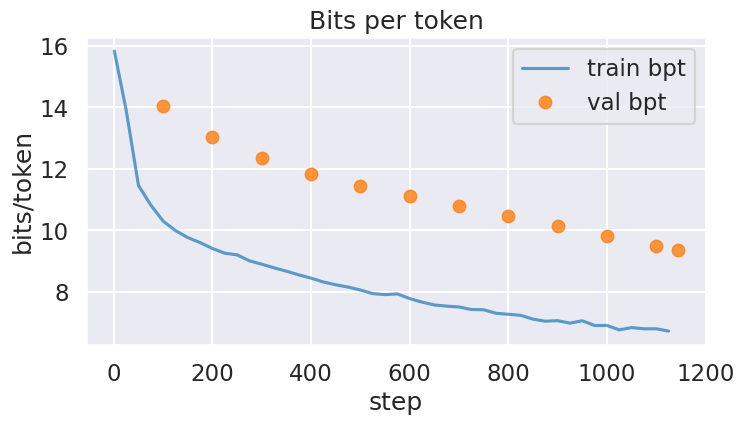

Saved figure: artifacts/bpt_train_val-20250830-214954.png


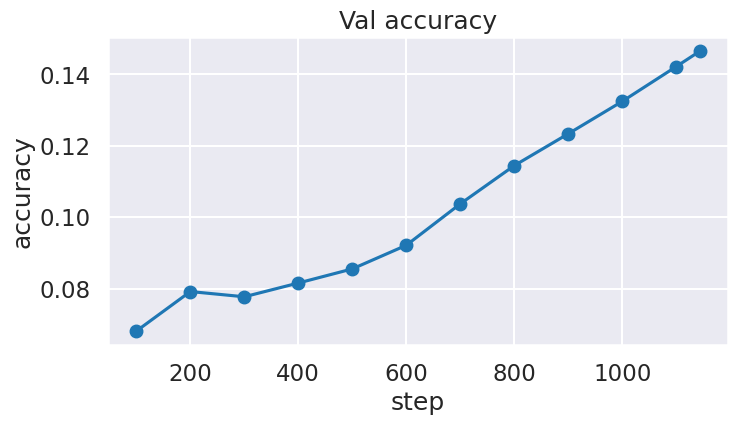

Saved figure: artifacts/val_accuracy-20250830-214954.png


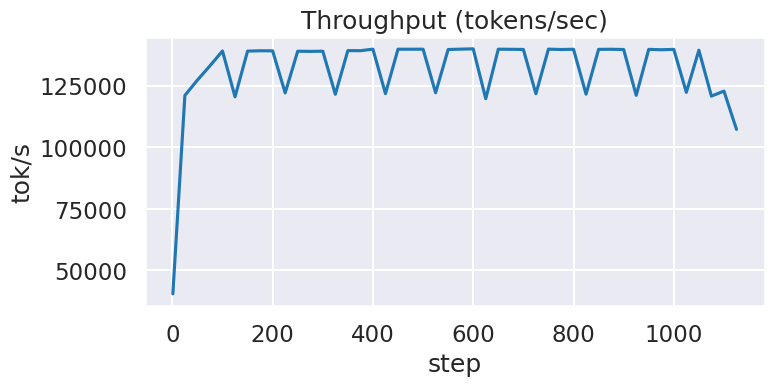

Saved figure: artifacts/throughput_tokps-20250830-214954.png


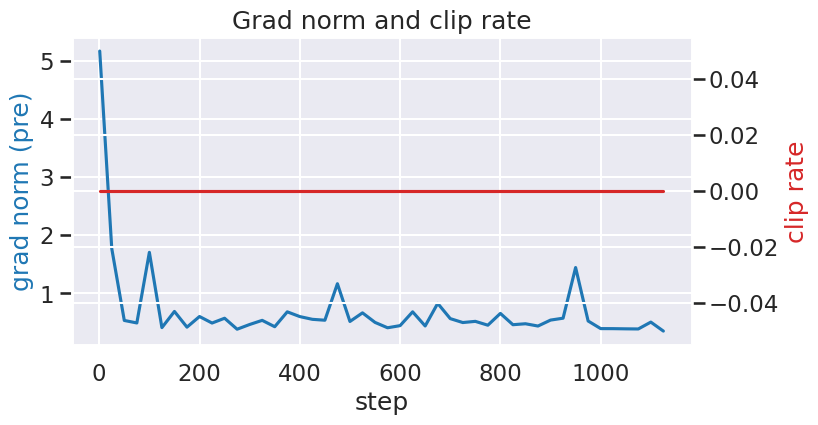

Saved figure: artifacts/grad_clip-20250830-214954.png


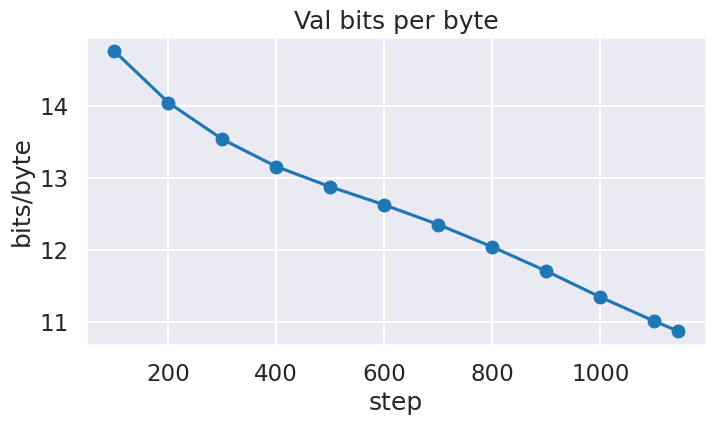

Saved figure: artifacts/val_bpb-20250830-214954.png


In [ ]:
sns.set_context("talk")
sns.set_style("darkgrid")

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)


def _ts() -> str:
    return datetime.now().strftime("%Y%m%d-%H%M%S")


def savefig(fig: plt.Figure, name: str) -> Path:
    path = ARTIFACTS_DIR / f"{name}-{_ts()}.png"
    fig.savefig(path, bbox_inches="tight", dpi=150)
    print(f"Saved figure: {path}")
    return path


def savejson(obj: Any, name: str) -> Path:
    def _default(o: Any):
        if isinstance(o, torch.Tensor):
            return o.detach().cpu().tolist()
        if isinstance(o, (np.floating, np.integer)):
            return o.item()
        return str(o)

    path = ARTIFACTS_DIR / f"{name}-{_ts()}.json"
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=_default)
    print(f"Saved JSON: {path}")
    return path

train_df, val_list, train_csv, val_jsonl = load_metrics()
print(f'Loaded train metrics: {train_csv}')
print(f'Loaded val metrics:   {val_jsonl}')

fig = plot_train_val_bpt(train_df, val_list);
display(fig); savefig(fig, 'bpt_train_val'); plt.close(fig)

fig = plot_val_accuracy(val_list)
if fig: display(fig); savefig(fig, 'val_accuracy'); plt.close(fig)

fig = plot_tokps(train_df)
if fig: display(fig); savefig(fig, 'throughput_tokps'); plt.close(fig)

fig = plot_grad_clip(train_df, window=10)
if fig: display(fig); savefig(fig, 'grad_clip'); plt.close(fig)

fig = plot_val_bpb(val_list)
if fig: display(fig); savefig(fig, 'val_bpb'); plt.close(fig)

fig = plot_loss_by_position_heatmap(val_list, max_rows=6)
if fig: display(fig); savefig(fig, 'loss_by_position_heatmap'); plt.close(fig)


In [ ]:
def reconstruct_lr_schedule(
    peak_lr: float, min_lr_ratio: float, warmup_steps: int, total_steps: int, hold_ratio: float = 0.5
) -> np.ndarray:
    warmup_steps = max(1, int(warmup_steps))
    total_steps = max(warmup_steps + 1, int(total_steps))
    min_lr = peak_lr * float(min_lr_ratio)
    remaining = max(1, total_steps - warmup_steps)
    hold_steps = max(0, int(remaining * float(hold_ratio)))
    decay_steps = max(1, total_steps - warmup_steps - hold_steps)
    lrs = []
    for s in range(1, total_steps + 1):
        if s <= warmup_steps:
            lr = peak_lr * (s / warmup_steps)
        elif s <= warmup_steps + hold_steps:
            lr = peak_lr
        else:
            t = min(decay_steps, max(0, s - warmup_steps - hold_steps))
            progress = t / decay_steps
            cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
            lr = min_lr + (peak_lr - min_lr) * cosine
        lrs.append(lr)
    return np.array(lrs, dtype=float)


def plot_lr_schedule(
    cfg: Config, total_steps: int, final_step: int | None = None, hold_ratio: float = 0.5
) -> plt.Figure:
    lrs = reconstruct_lr_schedule(
        cfg.peak_lr, cfg.min_lr_ratio, cfg.warmup_steps, total_steps, hold_ratio=hold_ratio
    )
    steps = np.arange(1, len(lrs) + 1)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(steps, lrs, label="LR")
    warmup_x = int(np.clip(cfg.warmup_steps, 1, len(lrs)))
    ax.axvline(x=warmup_x, color="orange", linestyle="--", label="warmup end")
    if final_step is not None:
        final_x = int(np.clip(final_step, 1, len(lrs)))
        ax.axvline(x=final_x, color="red", linestyle=":", label="final step")
    ax.set_xlabel("step")
    ax.set_ylabel("learning rate")
    ax.set_title("Warmup + Cosine LR")
    ax.legend()
    return fig


def plot_loss_by_position(
    metrics: dict, max_positions: int = 256
) -> Optional[plt.Figure]:
    lbp = metrics.get("loss_by_position", []) or []
    if not lbp:
        print("No loss_by_position available.")
        return None
    LOG2E_local = 1.0 / math.log(2.0)
    bits = np.array(lbp[:max_positions], dtype=float) * LOG2E_local
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(np.arange(len(bits)), bits)
    ax.set_xlabel("position")
    ax.set_ylabel("cross-entropy (bits)")
    ax.set_title("Loss by position (bits)")
    return fig


def plot_attention_distance_overlay(
    metrics: dict, max_distance: int = 256
) -> Optional[plt.Figure]:
    adh = metrics.get("attn_distance_hist", {}) or {}
    if not adh:
        print("No attention distance histograms available.")
        return None
    # Normalize keys to ints
    keys = sorted(int(k) for k in adh.keys())
    fig, ax = plt.subplots(figsize=(10, 5))
    for li in keys:
        hist = np.array(adh.get(li, None) or adh.get(str(li), None), dtype=float)
        hist = hist[:max_distance]
        distances = np.arange(len(hist), dtype=float)
        mass = hist.sum()
        if mass > 0:
            hist = hist / mass
        exp_d = float((hist * distances).sum()) if hist.size else 0.0
        ax.plot(distances, hist, label=f"layer {li} (E[d]={exp_d:.1f})")
    ax.set_xlabel("distance (tokens)")
    ax.set_ylabel("attention mass")
    ax.set_title("Attention distance distribution (overlay)")
    ax.legend()
    return fig


def plot_train_history(history: dict) -> Optional[plt.Figure]:
    if not history or not history.get("train"):
        print("No train history available.")
        return None
    import pandas as _pd

    df = _pd.DataFrame(history["train"])

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax = axes[0, 0]
    ax.plot(df["step"], df["lr"])
    ax.set_title("LR")
    ax.set_xlabel("step")
    ax.set_ylabel("lr")
    ax = axes[0, 1]
    ax.plot(df["step"], df["gnorm_pre"])
    ax.set_title("Grad norm (pre-clip)")
    ax.set_xlabel("step")
    ax.set_ylabel("||g||2")
    ax = axes[1, 0]
    ax.plot(df["step"], df["bpt_train"])
    ax.set_title("Bits per token (train)")
    ax.set_xlabel("step")
    ax.set_ylabel("bits")
    ax = axes[1, 1]
    ax.plot(df["step"], df.get("acc_train", 0))
    ax.set_title("Next-token accuracy (train)")
    ax.set_xlabel("step")
    ax.set_ylabel("acc")
    fig.tight_layout()
    return fig


def plot_val_history(history: dict) -> Optional[plt.Figure]:
    if not history or not history.get("val"):
        print("No val history available.")
        return None
    import pandas as _pd

    df = _pd.DataFrame(history["val"])
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax = axes[0]
    ax.plot(df["step"], df["bits_per_token"], marker="o")
    ax.set_title("Val bits/token")
    ax.set_xlabel("step")
    ax.set_ylabel("bits")
    ax = axes[1]
    ax.plot(df["step"], df.get("accuracy", 0), marker="o")
    ax.set_title("Val accuracy")
    ax.set_xlabel("step")
    ax.set_ylabel("acc")
    fig.tight_layout()
    return fig


def plot_bytes_per_token_hist(
    val_loader: DataLoader,
    tokenizer: HFTokenizerAdapter,
    bins: int = 30,
    max_tokens: int = 10_000,
) -> Optional[plt.Figure]:
    try:
        x, y = next(iter(val_loader))
    except StopIteration:
        print("val_loader is empty.")
        return None
    y_ids = y.view(-1)[:max_tokens]
    with torch.no_grad():
        lens = tokenizer.bytes_per_token(y_ids)
    arr = lens.detach().cpu().numpy().astype(float)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(arr, bins=bins, color="#4c72b0", edgecolor="white")
    ax.set_xlabel("bytes per token")
    ax.set_ylabel("count")
    ax.set_title("Bytes per token (sample)")
    return fig


@torch.no_grad()
def generate_text(
    model: DecoderOnlyLM,
    tokenizer: HFTokenizerAdapter,
    prompt: str,
    *,
    max_new_tokens: int = 64,
    temperature: float = 1.0,
    top_k: int = 50,
    top_p: float = 0.9,
    repetition_penalty: float = 1.1,
    device: Optional[torch.device] = None,
) -> str:
    device = device or next(model.parameters()).device
    model.eval()
    ids = tokenizer.encode(prompt)
    if len(ids) == 0:
        ids = [0]
    x = torch.tensor(
        ids[-cfg.max_seq_len :], dtype=torch.long, device=device
    ).unsqueeze(0)
    for _ in range(int(max_new_tokens)):
        logits, _ = model(x, need_attn_layers=None)
        logits = logits[:, -1, :]  # (1, V)
        if temperature is not None and temperature > 0:
            logits = logits / float(temperature)
        # repetition penalty (token-level)
        if repetition_penalty is not None and repetition_penalty != 1.0:
            prev = x[0]  # (T,)
            if prev.numel() > 0:
                uniq = torch.unique(prev)
                vals = logits.gather(1, uniq.view(1, -1))
                vals = torch.where(vals > 0, vals / repetition_penalty, vals * repetition_penalty)
                logits = logits.scatter(1, uniq.view(1, -1), vals)
        if top_p is not None and 0.0 < float(top_p) < 1.0:
            probs = torch.softmax(logits, dim=-1)
            sorted_probs, sorted_idx = torch.sort(probs, descending=True, dim=1)
            cum = torch.cumsum(sorted_probs, dim=1)
            keep = cum <= float(top_p)
            # ensure at least 1 token kept
            keep[:, 0] = True
            filt = torch.where(keep, sorted_probs, torch.zeros_like(sorted_probs))
            # renormalize
            filt = filt / torch.clamp(filt.sum(dim=1, keepdim=True), min=1e-12)
            next_sorted = torch.multinomial(filt, num_samples=1)
            next_id = sorted_idx.gather(1, next_sorted)
        else:
            if top_k is not None and top_k > 0:
                k = min(int(top_k), logits.size(-1))
                values, indices = torch.topk(logits, k, dim=1)
                mask = torch.full_like(logits, float("-inf"))
                logits = mask.scatter(1, indices, values)
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
        x = torch.cat([x, next_id], dim=1)
        if x.size(1) > cfg.max_seq_len:
            x = x[:, -cfg.max_seq_len :]
    out_ids = x[0].tolist()
    return tokenizer.decode(out_ids)

{'final_step': 1144, 'tokens_processed': 299892736, 'last_lr': 5.9999999999999995e-05, 'last_grad_norm': 0.41855287551879883, 'grad_accum_steps': 16, 'total_opt_steps': 1144, 'history': {'train': [{'step': 1, 'lr': 5.999999999999999e-06, 'gnorm_pre': 5.1680779457092285, 'bpt_train': 15.829800605773926, 'acc_train': 1.52587890625e-05, 'tok_per_sec': 40506.34002345843, 'tokens_done': 262144, 'clipped': False}, {'step': 25, 'lr': 0.00015, 'gnorm_pre': 1.7711106538772583, 'bpt_train': 13.905625343322754, 'acc_train': 0.043255966156721115, 'tok_per_sec': 121050.34452341747, 'tokens_done': 6553600, 'clipped': False}, {'step': 50, 'lr': 0.0003, 'gnorm_pre': 0.5340737104415894, 'bpt_train': 11.454090118408203, 'acc_train': 0.07704330235719681, 'tok_per_sec': 127291.02526051468, 'tokens_done': 13107200, 'clipped': False}, {'step': 75, 'lr': 0.0003, 'gnorm_pre': 0.4910695254802704, 'bpt_train': 10.819716453552246, 'acc_train': 0.10210739076137543, 'tok_per_sec': 133081.23762387838, 'tokens_done'

Saved figure: artifacts/lr_schedule-20250830-214954.png


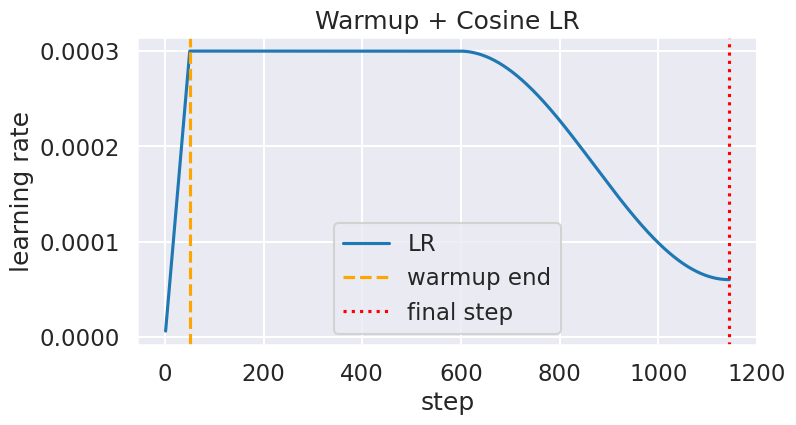

Saved figure: artifacts/train_history-20250830-214955.png


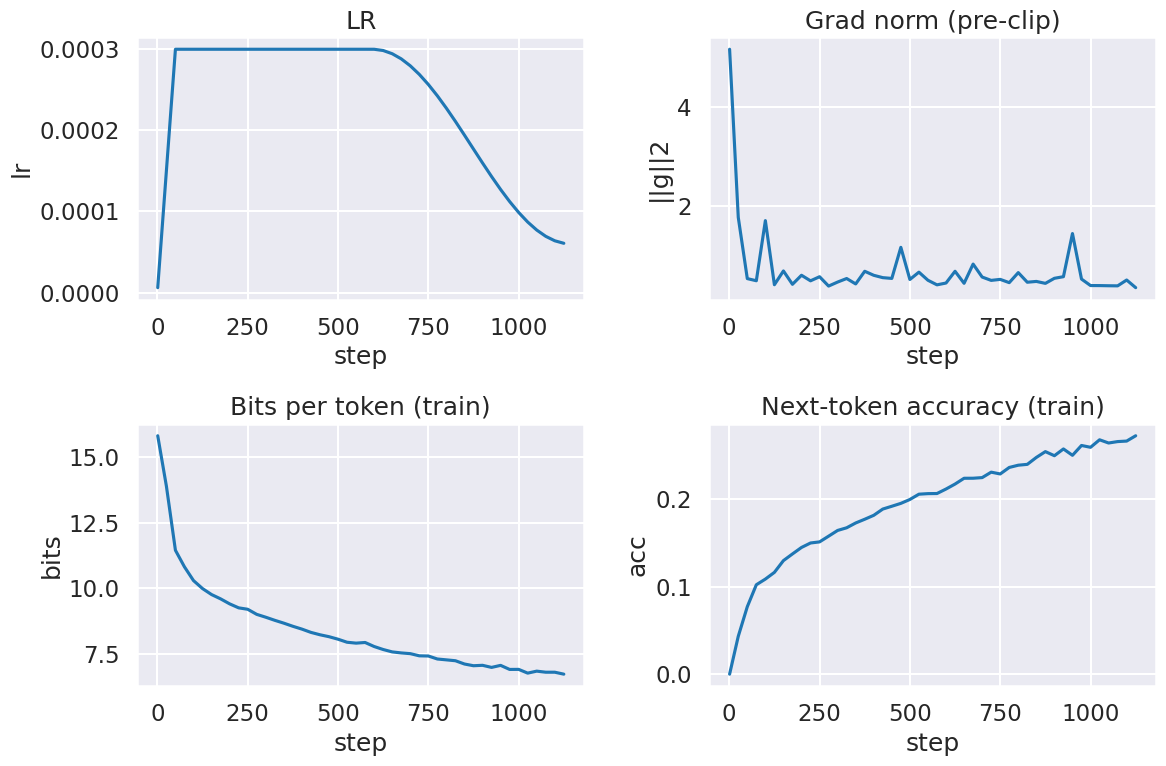

Saved figure: artifacts/val_history-20250830-214955.png


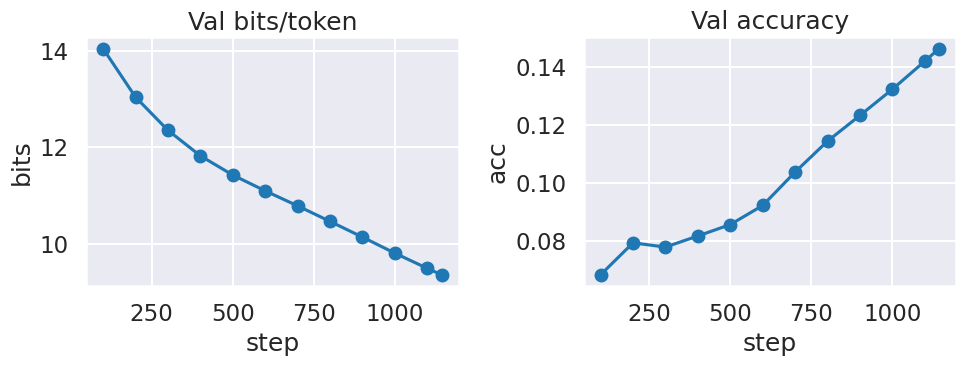

Saved figure: artifacts/loss_by_position_bits-20250830-214955.png


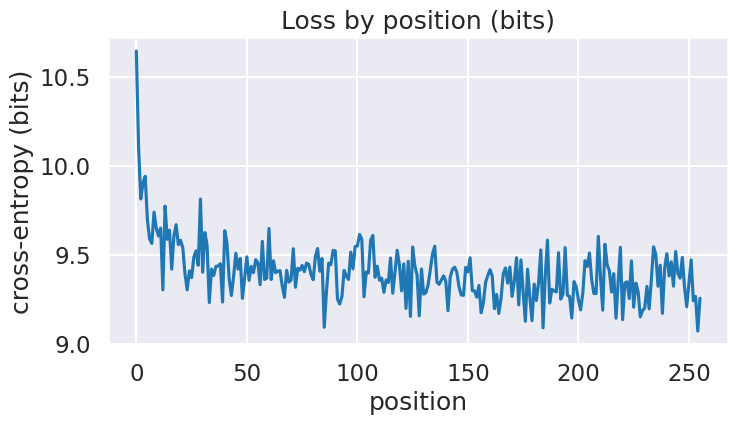

Saved figure: artifacts/attn_distance_overlay-20250830-214955.png


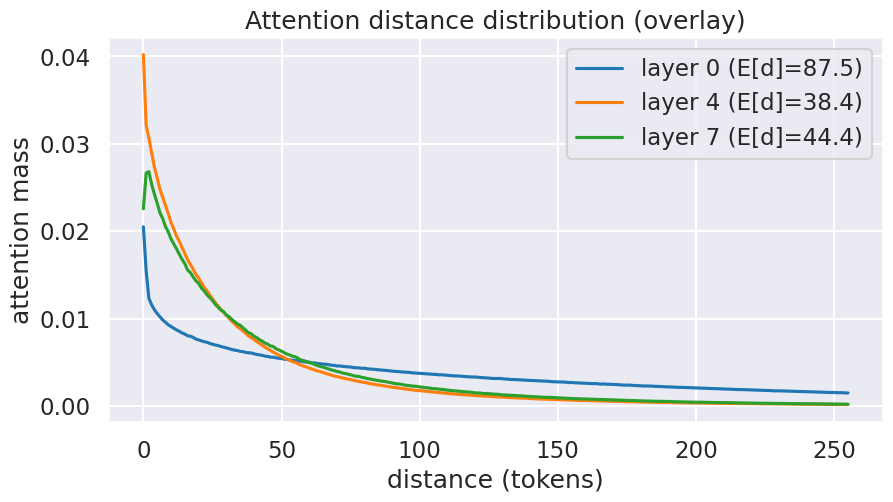

Saved figure: artifacts/bytes_per_token_hist-20250830-214958.png


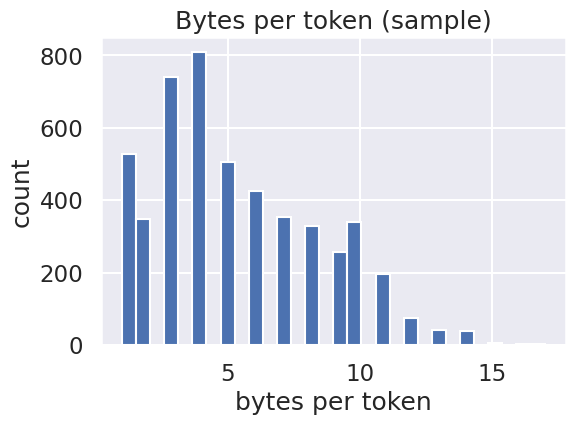



 === Generation === 
The history of machine learning began when the company had to be able to sell the industry, as well as the brand.

In 2014, the company began to develop an alternative company in a new market, which would re-authored with the company's own and their first generation from the company. The company had not been, but it did not attempt to be the first time of the company.

In 2021, the company
Saved generation: artifacts/generation-20250830-214959.txt


In [ ]:
# Pretty-print summary and save
print({k: v for k, v in summary.items() if k != "last_val_metrics"})
savejson(summary, "summary")


# LR schedule
fig_lr = plot_lr_schedule(
    cfg, total_steps=total_opt_steps, final_step=summary.get("final_step")
)
savefig(fig_lr, "lr_schedule")
plt.show(fig_lr)

# Train history (if available)
hist = summary.get("history") or {}
fig_hist = plot_train_history(hist)
if fig_hist is not None:
    savefig(fig_hist, "train_history")
    plt.show(fig_hist)

# Val history (if available)
fig_valhist = plot_val_history(hist)
if fig_valhist is not None:
    savefig(fig_valhist, "val_history")
    plt.show(fig_valhist)

# Loss by position (bits)
fig_lbp = plot_loss_by_position(summary.get("last_val_metrics", {}), max_positions=256)
if fig_lbp is not None:
    savefig(fig_lbp, "loss_by_position_bits")
    plt.show(fig_lbp)

# Attention distance overlay
fig_attn = plot_attention_distance_overlay(
    summary.get("last_val_metrics", {}), max_distance=256
)
if fig_attn is not None:
    savefig(fig_attn, "attn_distance_overlay")
    plt.show(fig_attn)

# Bytes per token histogram
fig_bpt = plot_bytes_per_token_hist(val_loader, tokenizer, bins=30, max_tokens=5000)
if fig_bpt is not None:
    savefig(fig_bpt, "bytes_per_token_hist")
    plt.show(fig_bpt)

# Text generation sanity check
PROMPT = "The history of machine learning began when"
gen_text = generate_text(
    model,
    tokenizer,
    prompt=PROMPT,
    max_new_tokens=80,
    temperature=0.7,
    top_k=32,
    device=device,
)
print("\n\n === Generation === ")
print(gen_text)
gen_path = ARTIFACTS_DIR / f"generation-{_ts()}.txt"
with open(gen_path, "w") as f:
    f.write(gen_text)
print(f"Saved generation: {gen_path}")

### thoughts

__runs__:

1. very short run, runs, completely incoherent  
2. scale to 200M tokens -> get a generation, mostly incoherent but not just repeats, get e.g. "D-GGG is the United States", 14 ish bits per byte  
3. fix weight decay from all -> skip e.g. embeddings; fix warm up iters -> 12.9 bits per byte. (also dropping temp 0.9->0.7 and top k 50->32 helped w/ coherency. should add top P sampling later.)
4. increase speed of learning: dropout .1->.05, wt decay .1->.05, min lr .2, grad clip 10->30; plus add EOS tokens - 12.7 bits per byte    
5. only decrease lrate after 50% iters (and other minor tweaks) -> way more coherent, 8.7 bits per byte  
6. use SDPA, should use flash attention; not expected to change model quality much -> negligible speed improvement at our very small context length  -> 11 bits per byte? must have changed something else  
7. microbatch 32->64 and fused adamw (again optimizing for speed) -> actually slower with batch sz 64 b/c nearly OOM? but then reducing to 48 should be fine and also slower? all the way back to 32 plus fused adamw gets us down to around 40mins from 55mins for 300M tokens
7.1. parallel dataloaders for speed -> no effect, seems like no bottleneck here.
8. activation/gradient checkpointing to reduce memory and increase batch sz -> w/ same batch size no real increase in time to run, nice. try 48 batch sz -> practically same time, maybe save 1-2 mins?. try batch sz 64 -> OOM. batch sz 54 -> same 43 ish mins?  

